In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import datetime

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 150)

In [2]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

Using TensorFlow backend.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#/kaggle/input/nfl-big-data-bowl-2020/train.csv
train = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'})
#train = pd.read_csv('../data/train.csv', usecols=['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis',
#                                                                              'Orientation', 'Dir', 'NflId', 'DisplayName', 'YardLine',
#                                                                               'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
#                                                                               'FieldPosition', 'NflIdRusher', 'OffenseFormation', 
#                                                                               'OffensePersonnel', 'DefendersInTheBox', 'DefensePersonnel', 
#                                                                               'PlayDirection', 'TimeHandoff', 'TimeSnap', 'Yards'])
#train = train[:2200]

In [5]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

## Functions for anchoring offense moving left from {0,0}

In [6]:
def create_features(df, deploy=False):
    
    def OffensePersonnelSplit(x):
        dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
        for xx in x.split(","):
            xxs = xx.split(" ")
            dic[xxs[-1]] = int(xxs[-2])
        return dic

    def DefensePersonnelSplit(x):
        dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
        for xx in x.split(","):
            xxs = xx.split(" ")
            dic[xxs[-1]] = int(xxs[-2])
        return dic

    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                                'YardLine','Quarter','Down','Distance','DefendersInTheBox',
                                                                'JerseyNumber','PlayerHeight','PlayerWeight','PossessionTeam',
                                                                'FieldPosition','PlayDirection','Team','TimeHandoff','TimeSnap',
                                                                'PlayerBirthDate','OffensePersonnel','DefensePersonnel']].drop_duplicates()
        
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))
        static_features['DefendersInTheBox_vs_Distance'] = static_features['DefendersInTheBox'] / static_features['Distance']  
        static_features['JerseyNumber_grouped'] = static_features['JerseyNumber'] // 10
        static_features['Height_feet'] = static_features['PlayerHeight'].apply(lambda x: int(x.split('-')[0]))
        static_features['PlayerHeight'] = static_features['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        static_features['BMI'] = (static_features['PlayerWeight'] * 703) / (static_features['PlayerHeight'] ** 2)
        static_features['TimeHandoff'] = static_features['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        static_features['TimeSnap'] = static_features['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        static_features['TimeDelta'] = static_features.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    #     static_features['Birth_year'] = static_features['PlayerBirthDate'].apply(lambda x: int(x.split('/')[2]))
        static_features['PlayerBirthDate'] = static_features['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        seconds_in_year = 60*60*24*365
        static_features['PlayerAge'] = static_features.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        static_features = static_features.drop(['TimeHandoff', 'TimeSnap', 'PlayerBirthDate'], axis=1)
        static_features['PlayDirection'] = static_features['PlayDirection'].apply(lambda x: x is 'right')

        # from https://www.kaggle.com/ryches/model-free-benchmark
        static_features['Field_eq_Possession'] = static_features['FieldPosition'] == static_features['PossessionTeam']

        return static_features


    def combine_features(relative_to_back, defense, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats, deploy=deploy)
    basetable.drop(['PossessionTeam','FieldPosition','Team'],axis=1,inplace=True)
    
    ## OffensePersonnel
    temp = basetable["OffensePersonnel"].apply(lambda x : pd.Series(OffensePersonnelSplit(x)))
    temp['Total']= temp.sum(axis=1)
    temp.columns = ["Offense" + c for c in temp.columns]
    temp["PlayId"] = basetable["PlayId"]
    basetable = basetable.merge(temp, on = "PlayId")
    basetable.drop(['OffensePersonnel'], axis=1, inplace=True)

    ## DefensePersonnel
    temp = basetable["DefensePersonnel"].apply(lambda x : pd.Series(DefensePersonnelSplit(x)))
    temp['Total']= temp.sum(axis=1)
    temp.columns = ["Defense" + c for c in temp.columns]
    temp["PlayId"] = basetable["PlayId"]
    basetable = basetable.merge(temp, on = "PlayId")
    basetable.drop(['DefensePersonnel'], axis=1, inplace=True)

    return basetable

In [7]:
%time train = create_features(train, False)

CPU times: user 1min 40s, sys: 2.16 s, total: 1min 42s
Wall time: 1min 36s


In [8]:
train_basetable = train.copy()

In [9]:
train_basetable.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,JerseyNumber,PlayerHeight,PlayerWeight,PlayDirection,DefendersInTheBox_vs_Distance,JerseyNumber_grouped,Height_feet,BMI,TimeDelta,PlayerAge,Field_eq_Possession,Yards,OffenseDB,OffenseDL,OffenseLB,OffenseOL,OffenseQB,OffenseRB,OffenseTE,OffenseWR,OffenseTotal,DefenseDB,DefenseDL,DefenseLB,DefenseOL,DefenseQB,DefenseRB,DefenseTE,DefenseWR,DefenseTotal
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,28,70,205,False,3.0,2,5,29.411224,1.0,25.613783,True,8,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,28,70,205,False,0.6,2,5,29.411224,1.0,25.613783,True,3,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,28,70,205,False,0.7,2,5,29.411224,2.0,25.613785,False,5,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,35,71,210,False,4.5,3,5,29.285856,2.0,26.871326,False,2,0,0,0,6,0,2,2,0,10,3,4,4,0,0,0,0,0,11
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,27,71,216,False,0.7,2,5,30.122595,1.0,22.106951,True,7,0,0,0,0,0,1,3,1,5,6,3,2,0,0,0,0,0,11


In [10]:
#train_basetable.drop(['JerseyNumber','PlayDirection','DefendersInTheBox_vs_Distance','JerseyNumber_grouped','Height_feet','BMI','TimeDelta','PlayerAge','Field_eq_Possession'],axis=1,inplace=True)

In [11]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['X','Y','S','A','Dis','Orientation','Dir','YardLine']#,'PlayerHeight','PlayerWeight','PlayerAge', 'BMI']

train_basetable = logs(train_basetable, log_features)

In [12]:
#train_basetable = train_basetable.loc[:, (train_basetable != 0).any(axis=0)]

In [13]:
train_basetable.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,JerseyNumber,PlayerHeight,PlayerWeight,PlayDirection,DefendersInTheBox_vs_Distance,JerseyNumber_grouped,Height_feet,BMI,TimeDelta,PlayerAge,Field_eq_Possession,Yards,OffenseDB,OffenseDL,OffenseLB,OffenseOL,OffenseQB,OffenseRB,OffenseTE,OffenseWR,OffenseTotal,DefenseDB,DefenseDL,DefenseLB,DefenseOL,DefenseQB,DefenseRB,DefenseTE,DefenseWR,DefenseTotal,X_log,Y_log,S_log,A_log,Dis_log,Orientation_log,Dir_log,YardLine_log
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,28,70,205,False,3.0,2,5,29.411224,1.0,25.613783,True,8,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11,3.743841,3.451257,1.534714,1.472472,0.329304,5.293456,4.747277,3.828859
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,28,70,205,False,0.6,2,5,29.411224,1.0,25.613783,True,3,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11,3.910822,3.338258,1.403643,1.229641,0.300105,5.012700,3.887935,3.989169
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,28,70,205,False,0.7,2,5,29.411224,2.0,25.613785,False,5,0,0,0,0,0,1,1,3,5,6,2,3,0,0,0,0,0,11,4.281515,3.001714,1.913977,1.232560,0.476234,5.394491,4.934834,4.330865
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,35,71,210,False,4.5,3,5,29.285856,2.0,26.871326,False,2,0,0,0,6,0,2,2,0,10,3,4,4,0,0,0,0,0,11,4.658521,3.272227,1.697449,1.437463,0.385262,5.163585,4.449335,4.691440
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,27,71,216,False,0.7,2,5,30.122595,1.0,22.106951,True,7,0,0,0,0,0,1,3,1,5,6,3,2,0,0,0,0,0,11,3.433987,3.336837,1.591274,1.264127,0.371564,3.563316,5.068464,3.583797


In [14]:
#features = list(train_basetable.columns)
#features.remove('Yards')
#features

In [19]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Let's build NN

In [62]:
X = train_basetable.copy()
yards = X.Yards

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

X.drop(['GameId','PlayId','Yards'], axis=1, inplace=True)

In [63]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=12345)

In [65]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(19695, 60) (3476, 60)
(19695, 199) (3476, 199)


In [20]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_train, y_train = self.data[0][0], self.data[0][1]
        y_pred = self.model.predict(X_train)
        y_true = np.clip(np.cumsum(y_train, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        tr_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_train.shape[0])
        tr_s = np.round(tr_s, 6)
        logs['tr_CRPS'] = tr_s

        X_valid, y_valid = self.data[1][0], self.data[1][1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        val_s = np.round(val_s, 6)
        logs['val_CRPS'] = val_s
        print('tr CRPS', tr_s, 'val CRPS', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [21]:
model = Sequential()
model.add(Dense(512, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(199, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[])

es = EarlyStopping(monitor='val_CRPS', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=15)
es.set_model(model)

metric = Metric(model, [es], [(X_train,y_train), (X_val,y_val)])

In [22]:
%%time
model.fit(X_train, y_train, callbacks=[metric], epochs=250, batch_size=1024)

Epoch 1/250
19695/19695 [==============================] - 1s 37us/step - loss: 3.8244
tr CRPS 0.014244 val CRPS 0.013891
Epoch 2/250
19695/19695 [==============================] - 0s 23us/step - loss: 3.0462
tr CRPS 0.014 val CRPS 0.013621
Epoch 3/250
19695/19695 [==============================] - 1s 30us/step - loss: 2.9464
tr CRPS 0.013829 val CRPS 0.013435
Epoch 4/250
19695/19695 [==============================] - 1s 28us/step - loss: 2.8929
tr CRPS 0.013716 val CRPS 0.013304
Epoch 5/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.8633
tr CRPS 0.01361 val CRPS 0.013201
Epoch 6/250
19695/19695 [==============================] - 0s 22us/step - loss: 2.8418
tr CRPS 0.013476 val CRPS 0.013076
Epoch 7/250
19695/19695 [==============================] - 0s 22us/step - loss: 2.8226
tr CRPS 0.013368 val CRPS 0.012965
Epoch 8/250
19695/19695 [==============================] - 0s 22us/step - loss: 2.8112
tr CRPS 0.013307 val CRPS 0.012928
Epoch 9/250
19695/19695 [===

19695/19695 [==============================] - 0s 25us/step - loss: 2.5056
tr CRPS 0.011672 val CRPS 0.012592
Epoch 69/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.5025
tr CRPS 0.011648 val CRPS 0.012579
Epoch 70/250
19695/19695 [==============================] - 1s 26us/step - loss: 2.4982
tr CRPS 0.011557 val CRPS 0.01248
Epoch 71/250
19695/19695 [==============================] - 1s 26us/step - loss: 2.4984
tr CRPS 0.011537 val CRPS 0.012512
Epoch 72/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.4876
tr CRPS 0.011514 val CRPS 0.012547
Epoch 73/250
19695/19695 [==============================] - 0s 23us/step - loss: 2.4813
tr CRPS 0.01151 val CRPS 0.012549
Epoch 74/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.4869
tr CRPS 0.011474 val CRPS 0.01255
Epoch 75/250
19695/19695 [==============================] - 0s 24us/step - loss: 2.4791
tr CRPS 0.011442 val CRPS 0.012498
Epoch 76/250
19695/19695 [======

In [46]:
pred_keras = model.predict(X)
print('Train RMSE for Keras is %f' % rmse(y, pred_keras))

Train RMSE for Keras is 1.054667


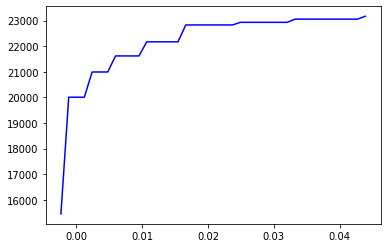

In [47]:
values, base = np.histogram(pred_keras, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.show()

# Let's build LightGBM

In [25]:
# Fazendo uma limpeza na memoria
gc.collect()

2596

In [29]:
# Setup cross validation folds
from sklearn.model_selection import KFold
kf = 5
folds = KFold(n_splits=kf, shuffle=False, random_state=42)
print(str(kf) + ' Folds para treino...')

5 Folds para treino...


In [30]:
# Identificando as features para o modelo
features = list(train_basetable.columns)
X = train_basetable[features]
print(len(features),' features')
np.array(features)

63  features


array(['GameId', 'PlayId', 'back_from_scrimmage',
       'back_oriented_down_field', 'back_moving_down_field', 'min_dist',
       'max_dist', 'mean_dist', 'std_dist', 'def_min_dist',
       'def_max_dist', 'def_mean_dist', 'def_std_dist', 'X', 'Y', 'S',
       'A', 'Dis', 'Orientation', 'Dir', 'YardLine', 'Quarter', 'Down',
       'Distance', 'DefendersInTheBox', 'JerseyNumber', 'PlayerHeight',
       'PlayerWeight', 'PlayDirection', 'DefendersInTheBox_vs_Distance',
       'JerseyNumber_grouped', 'Height_feet', 'BMI', 'TimeDelta',
       'PlayerAge', 'Field_eq_Possession', 'Yards', 'OffenseDB',
       'OffenseDL', 'OffenseLB', 'OffenseOL', 'OffenseQB', 'OffenseRB',
       'OffenseTE', 'OffenseWR', 'OffenseTotal', 'DefenseDB', 'DefenseDL',
       'DefenseLB', 'DefenseOL', 'DefenseQB', 'DefenseRB', 'DefenseTE',
       'DefenseWR', 'DefenseTotal', 'X_log', 'Y_log', 'S_log', 'A_log',
       'Dis_log', 'Orientation_log', 'Dir_log', 'YardLine_log'],
      dtype='<U29')

In [31]:
# Split de dados e label
X_train = pd.DataFrame(data=train_basetable,columns=features)
y_train_ = np.array([train_basetable["Yards"][i] for i in range(0,len(train_basetable))])

In [32]:
X_train.shape, y_train_.shape

((23171, 63), (23171,))

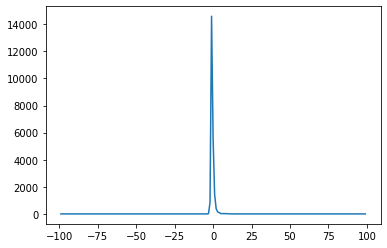

In [33]:
from sklearn import preprocessing
# Normalizacao das features 
y_tr = np.zeros(len(y_train_),dtype=np.float)
for i in range(len(y_tr)):
    y_tr[i]=(y_train_[i])

scaler = preprocessing.StandardScaler()
scaler.fit([[y] for y in y_tr])
y_tr = np.array([y[0] for y in scaler.transform([[y] for y in y_tr])])
data = [0 for i in range(199)]
for y in y_tr:
    data[int(y+99)]+=1
plt.plot([i-99 for i in range(199)],data)

In [34]:
def funcao_crps(labels,predictions) :
    y_pred = np.zeros((len(labels),199))
    y_ans = np.zeros((len(labels),199))
    j = np.array(range(199))
    for i,(p,t) in enumerate(zip(np.round(scaler.inverse_transform(predictions)),labels)) :
        k2 = j[j>=p-10]
        y_pred[i][k2]=(k2+10-p)*0.05
        k1 = j[j>=p+10]
        y_pred[i][k1]= 1.0
        k3 = j[j>=t]
        y_ans[i][k3]= 1.0
                           
    return 'CRPS: ', np.sum((y_pred-y_ans)**2)/(199*y_pred.shape[0]), False

In [35]:
best_params_lgb = {
    "boosting": "gbdt",
    "verbosity": -1,
    "num_leaves":3,
    "min_data_in_leaf": 10,
    "max_depth": -1,
    "learning_rate": 0.0005,
    "bagging_freq": 4,
    "bagging_fraction": 0.1,
    "bagging_seed": 11,
    "feature_fraction" : 1,
    "random_seed": 19,
    "metric": "rmse",
    "boost_from_average" : False
}

In [41]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

oof = np.zeros(len(X_train))
feature_importance_df = pd.DataFrame()

tr_rmse  = []
val_rmse = []
models   = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = train_basetable.iloc[trn_idx][features], train_basetable.iloc[val_idx][features]
    train_y, y_val = y_tr[trn_idx], y_tr[val_idx]

    model = lgb.LGBMRegressor(**best_params_lgb, n_estimators = 100, n_jobs = -1)
    model.fit(X_tr, 
              train_y, 
              eval_set=[(X_tr, train_y), (X_val, y_val)], 
              eval_metric=funcao_crps,
              verbose=10, 
              early_stopping_rounds=60)
    
    oof[val_idx] = model.predict(X_val)
    
    val_score = mean_squared_error(y_val, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(train_y, model.predict(X_tr))
    tr_rmse.append(tr_score)
    
    models.append(model)

fold 0
Training until validation scores don't improve for 60 rounds
[10]	training's rmse: 0.990267	training's CRPS: : 0.0119145	valid_1's rmse: 1.0215	valid_1's CRPS: : 0.0119691
[20]	training's rmse: 0.986901	training's CRPS: : 0.0119078	valid_1's rmse: 1.0182	valid_1's CRPS: : 0.0119597
[30]	training's rmse: 0.983385	training's CRPS: : 0.0119085	valid_1's rmse: 1.01459	valid_1's CRPS: : 0.0119604
[40]	training's rmse: 0.979918	training's CRPS: : 0.0119132	valid_1's rmse: 1.01122	valid_1's CRPS: : 0.0119647
[50]	training's rmse: 0.976687	training's CRPS: : 0.011986	valid_1's rmse: 1.00816	valid_1's CRPS: : 0.0120251
[60]	training's rmse: 0.973388	training's CRPS: : 0.0120021	valid_1's rmse: 1.00482	valid_1's CRPS: : 0.0120365
[70]	training's rmse: 0.970148	training's CRPS: : 0.0120021	valid_1's rmse: 1.00168	valid_1's CRPS: : 0.0120365
[80]	training's rmse: 0.966958	training's CRPS: : 0.0120158	valid_1's rmse: 0.998446	valid_1's CRPS: : 0.0120472
Early stopping, best iteration is:
[20

In [42]:
# Validacao do modelo
# Imprimir o score de treino e teste


mean_rmse_tr = np.mean(tr_rmse)
std_rmse_tr =  np.std(tr_rmse)

mean_rmse_val =  np.mean(val_rmse)
std_rmse_val =  np.std(val_rmse)

all_rmse = mean_squared_error(oof,y_tr)

print("Score de Treino")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_tr, std_rmse_tr),'\n')

print("Score de Validação")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_val, std_rmse_val),'\n')

print("Geral: %.5f." % (all_rmse),'\n')

print("CRPS: %.5f." % (funcao_crps(y_tr,oof)[1]))

#pred_lgb = model.predict(X_train)
print('Train RMSE for LGBM is %f' % rmse(y_tr, oof))

Score de Treino
Média RMSE: 0.98902, std: 0.03282. 

Score de Validação
Média RMSE: 0.98895, std: 0.12460. 

Geral: 0.98895. 

CRPS: 0.01192.
Train RMSE for LGBM is 0.994459


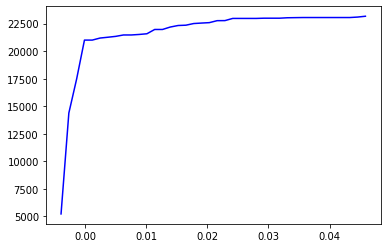

In [43]:
values, base = np.histogram(oof, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.show()

# Training meta features using LR and Keras

In [48]:
pred_keras.shape, oof.shape

((23171,), (23171,))

In [69]:
X_train_level2 = np.c_[pred_keras, oof]
X_train_level2.shape, y_train_.shape

((23171, 2), (23171,))

In [83]:
model_lgb_stacking = lgb.LGBMRegressor()
model_lgb_stacking.fit(X_train_level2, y_train_)
pred_stack = model_lgb_stacking.predict(X_train_level2)
rmse_train_stacking = rmse(y_train_, pred_stack)
print('Train RMSE for stacking is %f' % rmse_train_stacking)

Train RMSE for stacking is 1.938054


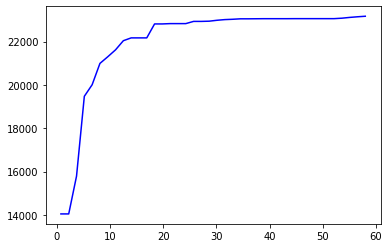

In [82]:
values, base = np.histogram(pred_stack, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='blue')
plt.show()

# Time for the actual submission

In [ ]:
class GP:
    def __init__(self):
        self.classes = 20
        self.class_names = [ 'class_0',
                             'class_1',
                             'class_2',
                             'class_3',
                             'class_4',
                             'class_5',
                             'class_6',
                             'class_7',
                             'class_8',
                             'class_9',
                             'class_10',
                             'class_11',
                             'class_12',
                             'class_13',
                            'class_14',
                            'class_15',
                            'class_16',
                            'class_17',
                            'class_18',
                            'class_19',
                           ]


    def GrabPredictions(self, data):
        oof_preds = np.zeros((len(data), len(self.class_names)))
        oof_preds[:,0] = self.GP_class_0(data)
        oof_preds[:,1] = self.GP_class_1(data)
        oof_preds[:,2] = self.GP_class_2(data)
        oof_preds[:,3] = self.GP_class_3(data)
        oof_preds[:,4] = self.GP_class_4(data)
        oof_preds[:,5] = self.GP_class_5(data)
        oof_preds[:,6] = self.GP_class_6(data)
        oof_preds[:,7] = self.GP_class_7(data)
        oof_preds[:,8] = self.GP_class_8(data)
        oof_preds[:,9] = self.GP_class_9(data)
        oof_preds[:,10] = self.GP_class_10(data)
        oof_preds[:,11] = self.GP_class_11(data)
        oof_preds[:,12] = self.GP_class_12(data)
        oof_preds[:,13] = self.GP_class_13(data)
        oof_preds[:,14] = self.GP_class_14(data)
        oof_preds[:,15] = self.GP_class_15(data)
        oof_preds[:,16] = self.GP_class_16(data)
        oof_preds[:,17] = self.GP_class_17(data)
        oof_preds[:,18] = self.GP_class_18(data)
        oof_preds[:,19] = self.GP_class_19(data)
        oof_df = pd.DataFrame(np.exp(oof_preds), columns=self.class_names)
        oof_df =oof_df.div(oof_df.sum(axis=1), axis=0)
        
        return oof_df.values


    def GP_class_0(self,data):
        return(0.250000*np.tanh(((((((data[:,0]) - (((data[:,0]) + (data[:,0]))))) + (data[:,0]))) + (((((data[:,0]) * 2.0)) * 2.0)))) +
                0.250000*np.tanh(((((((((((((data[:,2]) - (data[:,7]))) * 2.0)) + (data[:,7]))) * 2.0)) + (data[:,0]))) + (((((data[:,2]) + (data[:,0]))) - (data[:,7]))))) +
                0.250000*np.tanh(((((((((((((((((((data[:,3]) - (data[:,7]))) - (((data[:,0]) / 2.0)))) + (data[:,0]))) - (data[:,7]))) + (data[:,2]))) + (((data[:,7]) + (data[:,2]))))) + (data[:,7]))) - (data[:,7]))) + (data[:,0]))) +
                0.250000*np.tanh(((((((((data[:,0]) - (data[:,7]))) - (data[:,14]))) + (((data[:,17]) - (data[:,14]))))) + (((((((data[:,0]) - ((1.0)))) - (data[:,0]))) + (data[:,20]))))) +
                0.250000*np.tanh(((((data[:,18]) + (((((((data[:,0]) - (data[:,7]))) + (data[:,2]))) + (data[:,0]))))) - (((data[:,7]) + (data[:,2]))))) +
                0.250000*np.tanh((((((((data[:,8]) + ((((((((data[:,13]) + (data[:,3]))) + (data[:,0]))/2.0)) + ((((((((data[:,0]) + (((((data[:,0]) - (data[:,0]))) / 2.0)))) + (data[:,17]))/2.0)) + (data[:,11]))))))/2.0)) + (data[:,0]))) - (data[:,13]))) +
                0.250000*np.tanh(((((data[:,0]) * 2.0)) + (((((((((data[:,2]) + (data[:,2]))) * 2.0)) - (((data[:,14]) - (((np.tanh((data[:,2]))) * 2.0)))))) - (data[:,7]))))) +
                0.250000*np.tanh(((((((((((((data[:,17]) - (((data[:,17]) * (((((data[:,17]) * (data[:,17]))) * 2.0)))))) + (((((((data[:,17]) * 2.0)) * 2.0)) * 2.0)))/2.0)) / 2.0)) + (((data[:,17]) - ((7.76236486434936523)))))/2.0)) + (((((((data[:,17]) * (data[:,17]))) * 2.0)) * 2.0)))) +
                0.250000*np.tanh(((((((((((data[:,17]) + (data[:,17]))/2.0)) + ((((data[:,17]) + ((((data[:,17]) + (data[:,17]))/2.0)))/2.0)))/2.0)) * (data[:,17]))) - (data[:,13]))) +
                0.250000*np.tanh((((((data[:,19]) + (((((((((data[:,19]) * 2.0)) + (data[:,19]))) - ((1.07645297050476074)))) + (((data[:,22]) + (data[:,22]))))))/2.0)) + (((data[:,22]) + (data[:,4]))))))
    
    def GP_class_1(self,data):
        return(0.250000*np.tanh(((((((((((((data[:,3]) + (((np.tanh((data[:,2]))) - (data[:,14]))))) - ((10.0)))) - ((4.88989353179931641)))) - ((13.92175483703613281)))) / 2.0)) - (data[:,6]))) +
                0.250000*np.tanh(data[:,3]) +
                0.250000*np.tanh(((data[:,2]) + (((((np.tanh((((data[:,14]) * 2.0)))) - (((((((data[:,7]) * 2.0)) - (((((data[:,0]) - (data[:,14]))) - (data[:,7]))))) - (data[:,0]))))) + (data[:,0]))))) +
                0.250000*np.tanh(((((((data[:,0]) - ((-1.0*((data[:,14])))))) + ((((((((((data[:,0]) - (data[:,7]))) - ((((data[:,14]) + (data[:,14]))/2.0)))) + (((data[:,2]) - (((data[:,0]) * (data[:,14]))))))/2.0)) - (data[:,14]))))) - (data[:,7]))) +
                0.250000*np.tanh(((((data[:,0]) / 2.0)) + (data[:,0]))) +
                0.250000*np.tanh(((((data[:,19]) - (data[:,19]))) / 2.0)) +
                0.250000*np.tanh(((((np.tanh((((np.tanh((data[:,5]))) - ((((1.69341480731964111)) + ((((((np.tanh((data[:,14]))) - (data[:,14]))) + (data[:,14]))/2.0)))))))) - (data[:,2]))) - (((data[:,14]) * 2.0)))) +
                0.250000*np.tanh((((((data[:,22]) + (((data[:,0]) + ((((((((data[:,22]) / 2.0)) + ((-1.0*((data[:,13])))))/2.0)) + (data[:,19]))))))/2.0)) - (data[:,13]))) +
                0.250000*np.tanh(((((((data[:,17]) / 2.0)) * (data[:,17]))) * (((data[:,17]) + (((data[:,17]) * (((((((((data[:,17]) + (data[:,17]))) * (data[:,17]))) * (data[:,17]))) + (((np.tanh((data[:,17]))) / 2.0)))))))))) +
                0.250000*np.tanh((((((data[:,14]) * (((data[:,13]) + (data[:,3]))))) + (((data[:,14]) * (((data[:,14]) - ((-1.0*((data[:,3])))))))))/2.0)))
    
    def GP_class_2(self,data):
        return(0.250000*np.tanh(((data[:,0]) + (np.tanh((((((((((data[:,2]) + (((data[:,2]) / 2.0)))/2.0)) + (data[:,0]))/2.0)) * (data[:,7]))))))) +
                0.250000*np.tanh((((data[:,22]) + (data[:,22]))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) + ((-1.0*((((((4.73206138610839844)) + (((((((((((np.tanh((data[:,7]))) + (data[:,1]))/2.0)) - (np.tanh((((((data[:,0]) - (data[:,20]))) - (data[:,14]))))))) * ((7.0)))) + (data[:,14]))/2.0)))/2.0))))))/2.0)) - (data[:,14]))) +
                0.250000*np.tanh(((((data[:,1]) + ((4.15603733062744141)))) / 2.0)) +
                0.250000*np.tanh(((((((((((((data[:,0]) - (data[:,7]))) - (data[:,7]))) + ((((data[:,0]) + (data[:,0]))/2.0)))) * 2.0)) + (data[:,0]))) * 2.0)) +
                0.250000*np.tanh(((((data[:,11]) / 2.0)) / 2.0)) +
                0.250000*np.tanh(((((((((((((((((((((((data[:,2]) / 2.0)) + (((data[:,2]) / 2.0)))/2.0)) / 2.0)) / 2.0)) / 2.0)) + ((((-1.0*((((data[:,0]) / 2.0))))) * (((data[:,0]) / 2.0)))))/2.0)) + (data[:,0]))/2.0)) + (np.tanh((data[:,0]))))/2.0)) / 2.0)) +
                0.250000*np.tanh(((((data[:,0]) + (((data[:,0]) + (((((((data[:,14]) * (data[:,14]))) + (data[:,14]))) - (data[:,0]))))))) - (data[:,14]))) +
                0.250000*np.tanh((((((np.tanh((np.tanh(((0.0)))))) * (data[:,15]))) + (data[:,20]))/2.0)) +
                0.250000*np.tanh(((data[:,14]) * ((((data[:,13]) + ((((data[:,13]) + ((((data[:,14]) + ((((((data[:,14]) + ((((data[:,14]) + (((data[:,13]) - ((((-1.0*(((((data[:,14]) + (data[:,14]))/2.0))))) * 2.0)))))/2.0)))) + (data[:,14]))/2.0)))/2.0)))/2.0)))/2.0)))))
    
    def GP_class_3(self,data):
        return(0.250000*np.tanh(((((((((8.0)) + (((((((5.33416414260864258)) + ((9.0)))/2.0)) + ((((8.0)) * 2.0)))))) * 2.0)) + ((5.33416414260864258)))/2.0)) +
                0.250000*np.tanh((((9.48088836669921875)) + (((((10.56953334808349609)) + ((((4.48959350585937500)) + (np.tanh(((((3.0)) + ((9.0)))))))))/2.0)))) +
                0.250000*np.tanh((((((((((data[:,22]) / 2.0)) + (data[:,22]))/2.0)) * 2.0)) / 2.0)) +
                0.250000*np.tanh((10.44883441925048828)) +
                0.250000*np.tanh(((((data[:,0]) + (((data[:,0]) + ((-1.0*((data[:,9])))))))) + (((((data[:,0]) - (data[:,7]))) - (data[:,9]))))) +
                0.250000*np.tanh(((np.tanh((data[:,6]))) - (data[:,21]))) +
                0.250000*np.tanh(((data[:,0]) - (((((data[:,14]) + (((((data[:,14]) + (((data[:,14]) + (((data[:,14]) - (data[:,0]))))))) - (((((data[:,0]) - (data[:,14]))) + (data[:,14]))))))) - (((((data[:,14]) * (data[:,14]))) + (data[:,18]))))))) +
                0.250000*np.tanh(((data[:,14]) * ((((data[:,13]) + (data[:,14]))/2.0)))) +
                0.250000*np.tanh((((((data[:,8]) * (((data[:,8]) / 2.0)))) + ((((((data[:,9]) * (data[:,8]))) + (data[:,8]))/2.0)))/2.0)) +
                0.250000*np.tanh((((data[:,2]) + (((((((data[:,2]) + (data[:,20]))/2.0)) + ((((((((data[:,2]) + (data[:,8]))/2.0)) / 2.0)) - (data[:,8]))))/2.0)))/2.0)))
    
    def GP_class_4(self,data):
        return(0.250000*np.tanh((((12.98819637298583984)) / 2.0)) +
                0.250000*np.tanh(((((4.75780344009399414)) + (((((((8.66014671325683594)) + ((4.18107128143310547)))/2.0)) * ((8.97841739654541016)))))/2.0)) +
                0.250000*np.tanh((((9.0)) / 2.0)) +
                0.250000*np.tanh(((((((((((10.0)) + (np.tanh((((((6.0)) + ((((13.80149555206298828)) + ((7.0)))))/2.0)))))) + ((10.0)))) + (((((((data[:,0]) + ((8.0)))) / 2.0)) / 2.0)))/2.0)) + ((((-1.0*((((data[:,2]) * (data[:,9])))))) * 2.0)))) +
                0.250000*np.tanh(((((data[:,0]) + (((((((data[:,22]) + (data[:,22]))/2.0)) + (data[:,22]))/2.0)))) + ((((((data[:,22]) + ((((((data[:,22]) * 2.0)) + (data[:,22]))/2.0)))) + (data[:,18]))/2.0)))) +
                0.250000*np.tanh(((((((((((((np.tanh((data[:,18]))) + ((((data[:,1]) + (data[:,18]))/2.0)))/2.0)) * (data[:,18]))) * (data[:,18]))) + (((data[:,18]) * (data[:,18]))))/2.0)) - (((((((np.tanh((data[:,18]))) + (((data[:,18]) * (data[:,18]))))/2.0)) + (data[:,17]))/2.0)))) +
                0.250000*np.tanh(((np.tanh(((((((np.tanh((data[:,6]))) - (((np.tanh((data[:,6]))) - (data[:,6]))))) + (np.tanh((data[:,6]))))/2.0)))) - ((((data[:,10]) + ((((data[:,2]) + (((np.tanh((data[:,6]))) - (((np.tanh((np.tanh((data[:,6]))))) - (data[:,10]))))))/2.0)))/2.0)))) +
                0.250000*np.tanh((((((((((((data[:,10]) + (data[:,4]))) + (((data[:,10]) + (((data[:,0]) * (data[:,10]))))))/2.0)) + (((data[:,4]) * (((data[:,10]) + (data[:,4]))))))/2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh((((((data[:,11]) + (((((data[:,18]) / 2.0)) * (((data[:,11]) * (data[:,18]))))))/2.0)) * (((data[:,18]) * (((((((((data[:,18]) * (((((((data[:,11]) / 2.0)) / 2.0)) * (data[:,18]))))) / 2.0)) / 2.0)) * ((-1.0*((data[:,21])))))))))) +
                0.250000*np.tanh((((-1.0*((((((((((((data[:,2]) - (data[:,2]))) * (np.tanh((data[:,2]))))) + (np.tanh((((data[:,14]) * 2.0)))))/2.0)) + (data[:,2]))/2.0))))) - (data[:,2]))))
    
    def GP_class_5(self,data):
        return(0.250000*np.tanh(((((((((((3.46574378013610840)) + ((((np.tanh(((3.46574378013610840)))) + ((8.46705245971679688)))/2.0)))/2.0)) * 2.0)) + ((((3.46574378013610840)) + ((4.0)))))) + ((((4.0)) * 2.0)))) +
                0.250000*np.tanh((((10.55856513977050781)) / 2.0)) +
                0.250000*np.tanh((((3.76695251464843750)) / 2.0)) +
                0.250000*np.tanh((((((6.0)) / 2.0)) + ((((8.57984828948974609)) * 2.0)))) +
                0.250000*np.tanh((((((((((((3.42168045043945312)) + (data[:,7]))) + (np.tanh((data[:,7]))))) + (np.tanh((np.tanh((np.tanh(((3.42168045043945312)))))))))/2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh(((((((((((data[:,6]) - (data[:,9]))) + (data[:,7]))/2.0)) * 2.0)) + ((((((data[:,7]) + (data[:,9]))/2.0)) - (data[:,9]))))/2.0)) +
                0.250000*np.tanh(((((((((((data[:,22]) + (data[:,22]))) + (data[:,11]))/2.0)) + (data[:,22]))/2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((0.76044219732284546)) / 2.0)) + ((0.76044219732284546)))/2.0)) + (np.tanh((np.tanh((((((((0.76043862104415894)) / 2.0)) + ((1.0)))/2.0)))))))/2.0)) +
                0.250000*np.tanh(((((((data[:,12]) + (np.tanh((data[:,9]))))/2.0)) + (((((((((((data[:,12]) + (((((0.0)) + (np.tanh((((((((data[:,7]) + (data[:,6]))/2.0)) + (data[:,7]))/2.0)))))/2.0)))/2.0)) / 2.0)) / 2.0)) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((data[:,20]) / 2.0)) / 2.0)) * (((np.tanh((data[:,20]))) * (((data[:,20]) / 2.0)))))) * ((((((data[:,20]) / 2.0)) + (((data[:,20]) / 2.0)))/2.0)))))
    
    def GP_class_6(self,data):
        return(0.250000*np.tanh(((((((11.68076229095458984)) + (((((11.68075847625732422)) + ((((11.47270107269287109)) + (((((11.47269725799560547)) + ((11.68076229095458984)))/2.0)))))/2.0)))/2.0)) + ((((4.0)) * 2.0)))) +
                0.250000*np.tanh((((8.0)) + ((((10.0)) + ((6.59042119979858398)))))) +
                0.250000*np.tanh(((((((((((13.33760547637939453)) + (((((3.86388397216796875)) + (((((((8.18321037292480469)) + (data[:,4]))) + (((((((5.95386552810668945)) + ((12.93883609771728516)))) + (((((10.73907089233398438)) + ((4.0)))/2.0)))/2.0)))/2.0)))/2.0)))/2.0)) + (np.tanh(((3.0)))))) - ((2.0)))) + (((((10.61559963226318359)) + (data[:,1]))/2.0)))) +
                0.250000*np.tanh(((np.tanh(((((((((((7.13513946533203125)) + ((12.48778533935546875)))/2.0)) + (((((((7.13513565063476562)) - ((8.12031841278076172)))) + (((((((((7.13513565063476562)) + ((((10.69830417633056641)) + ((10.69830799102783203)))))) + ((10.69830799102783203)))) + ((7.83078956604003906)))/2.0)))/2.0)))/2.0)) * 2.0)))) + ((3.0)))) +
                0.250000*np.tanh(((((((((((data[:,7]) - (data[:,0]))) * 2.0)) - (data[:,7]))) + (data[:,7]))) + (data[:,0]))) +
                0.250000*np.tanh(((((data[:,7]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((((((((1.0)) + (((((((data[:,2]) + (((((((1.0)) * (data[:,2]))) + (data[:,14]))/2.0)))/2.0)) + ((1.0)))/2.0)))) + ((((1.0)) - (((data[:,2]) * (data[:,14]))))))/2.0)) - (data[:,2]))) * 2.0)) + (data[:,14]))/2.0)) + (data[:,14]))) +
                0.250000*np.tanh(((np.tanh((np.tanh(((((((data[:,19]) * ((0.0)))) + ((0.0)))/2.0)))))) / 2.0)) +
                0.250000*np.tanh((((((((0.0)) / 2.0)) / 2.0)) * (((((((((data[:,15]) / 2.0)) * ((0.0)))) / 2.0)) * ((((-1.0*(((0.0))))) / 2.0)))))) +
                0.250000*np.tanh(((((data[:,15]) * (((((((((((((np.tanh(((((0.09032609313726425)) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)))) / 2.0)))
    
    def GP_class_7(self,data):
        return(0.250000*np.tanh((10.27210903167724609)) +
                0.250000*np.tanh((((((((((10.0)) + (((((((((8.26972770690917969)) + ((11.06334972381591797)))/2.0)) * 2.0)) / 2.0)))) + ((((((5.0)) + ((((5.0)) + ((7.92727756500244141)))))) * 2.0)))) * ((7.92728137969970703)))) + ((10.0)))) +
                0.250000*np.tanh((8.42519950866699219)) +
                0.250000*np.tanh(((((((data[:,14]) + (data[:,14]))) + ((((((1.59392631053924561)) + (data[:,14]))) + (data[:,14]))))) + (np.tanh((((((data[:,14]) + (((((((3.0)) + (((data[:,14]) * 2.0)))/2.0)) + ((1.59391915798187256)))))) + ((1.59392631053924561)))))))) +
                0.250000*np.tanh((((data[:,7]) + (((data[:,0]) + (((((((data[:,7]) + (data[:,4]))/2.0)) + (((data[:,7]) * 2.0)))/2.0)))))/2.0)) +
                0.250000*np.tanh((((((((((((((data[:,9]) - (((data[:,0]) - (data[:,0]))))) - (((data[:,0]) / 2.0)))) / 2.0)) - (((data[:,21]) - (data[:,7]))))) + (data[:,21]))/2.0)) - (data[:,0]))) +
                0.250000*np.tanh((((((((((2.0)) + ((((((data[:,21]) + ((((data[:,13]) + (((((((((((data[:,13]) * 2.0)) + (data[:,21]))/2.0)) + (data[:,13]))/2.0)) * 2.0)))/2.0)))/2.0)) - (np.tanh(((((0.0)) - (data[:,21]))))))))) + ((1.0)))/2.0)) + (data[:,13]))/2.0)) +
                0.250000*np.tanh(((((data[:,14]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((((((((-1.0*(((((((data[:,21]) / 2.0)) + (data[:,8]))/2.0))))) / 2.0)) / 2.0)) / 2.0)) + (data[:,9]))/2.0)) / 2.0)) + ((((((((((((data[:,7]) / 2.0)) / 2.0)) / 2.0)) / 2.0)) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((np.tanh(((1.0)))) / 2.0)) / 2.0)) / 2.0)))
    
    def GP_class_8(self,data):
        return(0.250000*np.tanh(((((((data[:,0]) + (((((6.71804094314575195)) + (data[:,15]))/2.0)))) + ((((((11.56385326385498047)) * 2.0)) * ((((10.48986148834228516)) + ((11.56385326385498047)))))))) / 2.0)) +
                0.250000*np.tanh((((((((((data[:,14]) / 2.0)) + ((2.83755254745483398)))/2.0)) + ((((((data[:,12]) + (data[:,14]))/2.0)) + (data[:,14]))))) + ((((data[:,9]) + (((data[:,12]) + (data[:,14]))))/2.0)))) +
                0.250000*np.tanh(((((((((data[:,6]) + (((((((3.50821948051452637)) + ((((data[:,21]) + ((11.92932796478271484)))/2.0)))) + ((1.0)))/2.0)))) + (data[:,10]))/2.0)) + (data[:,21]))/2.0)) +
                0.250000*np.tanh(((data[:,14]) + (np.tanh((np.tanh(((-1.0*((((data[:,22]) - (data[:,13])))))))))))) +
                0.250000*np.tanh(((((1.0)) + ((((data[:,7]) + (data[:,7]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((data[:,21]) / 2.0)) / 2.0)) * (((((((np.tanh((((np.tanh((data[:,13]))) / 2.0)))) / 2.0)) + (((((((np.tanh(((((data[:,21]) + (data[:,21]))/2.0)))) / 2.0)) - (data[:,12]))) / 2.0)))) / 2.0)))) - (data[:,12]))) +
                0.250000*np.tanh((((data[:,7]) + (np.tanh(((((data[:,12]) + (((data[:,7]) * ((((data[:,13]) + (data[:,13]))/2.0)))))/2.0)))))/2.0)) +
                0.250000*np.tanh(((((((data[:,13]) / 2.0)) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((((np.tanh((data[:,9]))) + (data[:,13]))/2.0)) + ((((((((data[:,21]) / 2.0)) * 2.0)) + ((((3.94983267784118652)) / 2.0)))/2.0)))/2.0)) + ((((np.tanh(((3.94983267784118652)))) + (data[:,9]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((((((((((data[:,14]) * (((((((((data[:,19]) / 2.0)) * (np.tanh((((data[:,2]) / 2.0)))))) / 2.0)) / 2.0)))) / 2.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)) * (((((data[:,11]) / 2.0)) / 2.0)))))
    
    def GP_class_9(self,data):
        return(0.250000*np.tanh(((((((data[:,14]) * 2.0)) / 2.0)) + (((((data[:,14]) + (np.tanh((((data[:,14]) * 2.0)))))) + (data[:,14]))))) +
                0.250000*np.tanh(((data[:,9]) - (((((-1.0*((data[:,11])))) + (data[:,9]))/2.0)))) +
                0.250000*np.tanh(((data[:,21]) * 2.0)) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,14]))/2.0)) + ((((data[:,13]) + ((((np.tanh((((data[:,9]) + ((6.0)))))) + (data[:,9]))/2.0)))/2.0)))) +
                0.250000*np.tanh(np.tanh(((1.0)))) +
                0.250000*np.tanh(((np.tanh((np.tanh(((((np.tanh((((data[:,20]) * (((((((np.tanh((((data[:,20]) / 2.0)))) + (data[:,12]))/2.0)) + ((((data[:,15]) + ((((data[:,17]) + (data[:,9]))/2.0)))/2.0)))/2.0)))))) + (data[:,9]))/2.0)))))) / 2.0)) +
                0.250000*np.tanh(((((data[:,2]) - (data[:,11]))) / 2.0)) +
                0.250000*np.tanh((((((((data[:,13]) / 2.0)) + (((data[:,7]) + (data[:,7]))))/2.0)) - (((((data[:,22]) + (((((data[:,14]) * (((((data[:,7]) * (((data[:,13]) - ((((data[:,7]) + (((((data[:,13]) / 2.0)) + (data[:,7]))))/2.0)))))) / 2.0)))) * 2.0)))) / 2.0)))) +
                0.250000*np.tanh(((((((((((((((data[:,1]) / 2.0)) + ((1.0)))/2.0)) + ((1.0)))/2.0)) + ((((((((((1.0)) / 2.0)) + (np.tanh(((1.0)))))/2.0)) + (np.tanh((((((1.0)) + ((1.0)))/2.0)))))/2.0)))/2.0)) + ((((data[:,20]) + ((1.0)))/2.0)))/2.0)) +
                0.250000*np.tanh(((data[:,1]) * ((((data[:,14]) + (np.tanh(((((0.0)) / 2.0)))))/2.0)))))
    
    def GP_class_10(self,data):
        return(0.250000*np.tanh((((((((((data[:,2]) + (((data[:,9]) * (np.tanh((data[:,14]))))))/2.0)) + ((((((data[:,14]) + (data[:,20]))/2.0)) + (data[:,0]))))/2.0)) + (data[:,14]))/2.0)) +
                0.250000*np.tanh((((((data[:,9]) + ((-1.0*((((((((2.04309988021850586)) + (((data[:,11]) + (((np.tanh((data[:,0]))) / 2.0)))))/2.0)) * 2.0))))))/2.0)) + (data[:,2]))) +
                0.250000*np.tanh(data[:,21]) +
                0.250000*np.tanh((((((((data[:,14]) + (np.tanh((((data[:,6]) / 2.0)))))/2.0)) + (data[:,14]))) + (((((data[:,14]) * 2.0)) + ((((data[:,13]) + (data[:,14]))/2.0)))))) +
                0.250000*np.tanh(data[:,9]) +
                0.250000*np.tanh(((((((data[:,15]) * 2.0)) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((((((2.72836518287658691)) * ((((1.0)) / 2.0)))) / 2.0)) / 2.0)) +
                0.250000*np.tanh(((((np.tanh((((data[:,7]) + (np.tanh(((((((((((0.0)) / 2.0)) / 2.0)) / 2.0)) / 2.0)))))))) / 2.0)) / 2.0)) +
                0.250000*np.tanh(np.tanh((((np.tanh(((11.43236827850341797)))) / 2.0)))) +
                0.250000*np.tanh(np.tanh((((data[:,7]) / 2.0)))))
    
    def GP_class_11(self,data):
        return(0.250000*np.tanh((-1.0*((((((((((((((data[:,5]) - (((data[:,9]) - ((((-1.0*(((11.40053558349609375))))) / 2.0)))))) + ((((11.40053558349609375)) + ((((11.40053558349609375)) * 2.0)))))) / 2.0)) - (data[:,7]))) - ((-1.0*(((11.40053939819335938))))))) * 2.0))))) +
                0.250000*np.tanh(((((data[:,14]) * 2.0)) + (data[:,14]))) +
                0.250000*np.tanh(((data[:,2]) + (((((data[:,5]) + (data[:,3]))) + ((((data[:,2]) + (((data[:,3]) * 2.0)))/2.0)))))) +
                0.250000*np.tanh(((((((((((data[:,21]) + (data[:,21]))) + ((-1.0*(((((np.tanh((np.tanh((((data[:,14]) / 2.0)))))) + (data[:,21]))/2.0))))))/2.0)) * 2.0)) + ((((data[:,14]) + (data[:,3]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((((data[:,0]) + ((((data[:,9]) + ((((data[:,9]) + (((((((((((((((data[:,9]) / 2.0)) - (data[:,10]))) + (data[:,5]))/2.0)) - (data[:,9]))) + (data[:,9]))/2.0)) / 2.0)))/2.0)))/2.0)))/2.0)) + (data[:,9]))/2.0)) +
                0.250000*np.tanh((((((((data[:,13]) + ((((data[:,13]) + (data[:,13]))/2.0)))) + (data[:,1]))/2.0)) / 2.0)) +
                0.250000*np.tanh(data[:,14]) +
                0.250000*np.tanh(((((data[:,2]) / 2.0)) / 2.0)) +
                0.250000*np.tanh((((data[:,9]) + (data[:,9]))/2.0)) +
                0.250000*np.tanh(data[:,2]))
    
    def GP_class_12(self,data):
        return(0.250000*np.tanh((((((((-1.0*((data[:,18])))) - (np.tanh((data[:,9]))))) + ((8.0)))) - ((14.74865913391113281)))) +
                0.250000*np.tanh((((((data[:,21]) + (np.tanh((data[:,9]))))) + ((((((((data[:,5]) / 2.0)) * 2.0)) + (data[:,5]))/2.0)))/2.0)) +
                0.250000*np.tanh(((((data[:,14]) + (data[:,14]))) + (((data[:,14]) * 2.0)))) +
                0.250000*np.tanh(((data[:,2]) + (((((((data[:,14]) + ((((np.tanh((data[:,10]))) + (data[:,17]))/2.0)))/2.0)) + (data[:,21]))/2.0)))) +
                0.250000*np.tanh((((data[:,9]) + ((((((((((((data[:,9]) + ((((((data[:,9]) / 2.0)) + (((data[:,9]) * 2.0)))/2.0)))/2.0)) + ((-1.0*((data[:,21])))))/2.0)) * (data[:,9]))) + (((((np.tanh((((data[:,21]) / 2.0)))) / 2.0)) / 2.0)))/2.0)))/2.0)) +
                0.250000*np.tanh(((((0.0)) + (data[:,13]))/2.0)) +
                0.250000*np.tanh((((((((data[:,2]) / 2.0)) * 2.0)) + (data[:,7]))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) * 2.0)) + (np.tanh((data[:,14]))))/2.0)) +
                0.250000*np.tanh(np.tanh((((((((((-1.0*((((np.tanh((data[:,9]))) / 2.0))))) / 2.0)) / 2.0)) + (((data[:,3]) * (data[:,13]))))/2.0)))) +
                0.250000*np.tanh((-1.0*((((((((-1.0*(((((((-1.0*((data[:,18])))) - ((((0.0)) / 2.0)))) / 2.0))))) + (np.tanh(((((-1.0*(((-1.0*((data[:,22]))))))) / 2.0)))))/2.0)) / 2.0))))))
    
    def GP_class_13(self,data):
        return(0.250000*np.tanh(((((np.tanh((np.tanh((data[:,2]))))) - ((10.0)))) - (np.tanh((((((data[:,7]) - ((((((6.0)) - ((4.87243366241455078)))) - ((9.0)))))) - ((14.80352973937988281)))))))) +
                0.250000*np.tanh(((np.tanh((((((3.0)) + (data[:,1]))/2.0)))) - ((7.0)))) +
                0.250000*np.tanh(((((np.tanh((np.tanh((np.tanh((data[:,6]))))))) * 2.0)) - ((6.10337877273559570)))) +
                0.250000*np.tanh(((((((data[:,9]) + (data[:,14]))) + (data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((((np.tanh(((((-1.0*(((((((data[:,2]) + ((10.0)))/2.0)) / 2.0))))) - ((13.28130435943603516)))))) + ((10.0)))) - ((13.28130435943603516)))) + ((-1.0*((data[:,5])))))) +
                0.250000*np.tanh(((((((((((data[:,20]) + (((((((((data[:,20]) * 2.0)) * 2.0)) * 2.0)) + (data[:,13]))))/2.0)) + (((data[:,9]) + (((data[:,9]) + (((data[:,6]) + (data[:,9]))))))))/2.0)) + (data[:,20]))) + (data[:,15]))) +
                0.250000*np.tanh(((((((((data[:,14]) / 2.0)) + ((((data[:,9]) + (((data[:,15]) + (((data[:,5]) + ((((((data[:,9]) + (((data[:,5]) + (data[:,14]))))) + (data[:,9]))/2.0)))))))/2.0)))) * 2.0)) + (data[:,14]))) +
                0.250000*np.tanh((((data[:,13]) + (data[:,7]))/2.0)) +
                0.250000*np.tanh(((data[:,9]) + ((((data[:,3]) + ((((data[:,21]) + (data[:,3]))/2.0)))/2.0)))) +
                0.250000*np.tanh((((data[:,2]) + (((((((((((((((data[:,20]) + (data[:,1]))) + (((data[:,2]) + (data[:,14]))))) + (data[:,2]))) + (np.tanh((data[:,2]))))/2.0)) + (((data[:,14]) + (data[:,2]))))) + (data[:,14]))/2.0)))/2.0)))
    
    def GP_class_14(self,data):
        return(0.250000*np.tanh((((((((((((5.54024744033813477)) - ((((((9.0)) * 2.0)) * 2.0)))) - (data[:,0]))) - ((((7.0)) + ((4.74105215072631836)))))) - (((((7.0)) + (((data[:,5]) * 2.0)))/2.0)))) - ((9.0)))) +
                0.250000*np.tanh(((((((((9.0)) - ((14.27298927307128906)))) - (data[:,0]))) + (np.tanh(((((12.77708148956298828)) - ((14.80560111999511719)))))))/2.0)) +
                0.250000*np.tanh(((((((0.0)) + ((-1.0*((((data[:,22]) + (((((((((13.30077362060546875)) - (np.tanh((data[:,4]))))) + (((data[:,22]) / 2.0)))/2.0)) / 2.0))))))))/2.0)) - (((np.tanh((((data[:,7]) - (data[:,7]))))) / 2.0)))) +
                0.250000*np.tanh(((((((data[:,6]) + (data[:,14]))/2.0)) + (((np.tanh((((((data[:,14]) + (data[:,14]))) + (((data[:,6]) - (((data[:,5]) + (((np.tanh((data[:,21]))) + ((((data[:,14]) + ((((data[:,14]) + (data[:,14]))/2.0)))/2.0)))))))))))) + (data[:,5]))))/2.0)) +
                0.250000*np.tanh((((((((((((((((((data[:,2]) + (data[:,16]))) + ((((((data[:,2]) / 2.0)) + (data[:,9]))/2.0)))/2.0)) + (np.tanh((data[:,10]))))/2.0)) + (data[:,9]))) + (data[:,9]))/2.0)) + (data[:,21]))) + (data[:,3]))) +
                0.250000*np.tanh((((data[:,13]) + (((((((((((data[:,3]) / 2.0)) / 2.0)) / 2.0)) * (data[:,3]))) / 2.0)))/2.0)) +
                0.250000*np.tanh(((data[:,14]) + (((((((data[:,14]) / 2.0)) + (data[:,14]))) * 2.0)))) +
                0.250000*np.tanh(data[:,9]) +
                0.250000*np.tanh(((data[:,1]) / 2.0)) +
                0.250000*np.tanh((((((data[:,2]) + ((((((data[:,13]) + (data[:,14]))) + (data[:,13]))/2.0)))) + (np.tanh((data[:,2]))))/2.0)))
    
    def GP_class_15(self,data):
        return(0.250000*np.tanh((((((((4.0)) + ((((8.0)) / 2.0)))) - ((9.56193733215332031)))) - (((((np.tanh(((13.93556308746337891)))) - (data[:,18]))) + ((13.93556308746337891)))))) +
                0.250000*np.tanh(((data[:,4]) - ((((12.76094818115234375)) - (data[:,8]))))) +
                0.250000*np.tanh((((-1.0*(((12.35446166992187500))))) - (((((12.35446166992187500)) + ((((((12.35446166992187500)) - ((-1.0*(((0.0))))))) - (data[:,0]))))/2.0)))) +
                0.250000*np.tanh(((data[:,21]) - ((14.46367263793945312)))) +
                0.250000*np.tanh(((((data[:,2]) + ((((data[:,9]) + ((-1.0*(((-1.0*(((-1.0*((((data[:,7]) * (((data[:,21]) * 2.0))))))))))))))/2.0)))) + (data[:,9]))) +
                0.250000*np.tanh(((((((((((data[:,7]) + (data[:,3]))/2.0)) + (data[:,20]))/2.0)) - ((((2.33354020118713379)) / 2.0)))) - ((((2.0)) + ((8.78930377960205078)))))) +
                0.250000*np.tanh(((((((data[:,14]) + (((((((data[:,14]) + (((data[:,15]) + (data[:,14]))))) + (((data[:,15]) + (data[:,14]))))) + (((data[:,14]) / 2.0)))))) + (data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((((((data[:,13]) + (data[:,13]))) + (((data[:,13]) + (data[:,12]))))) + (data[:,9]))) + ((((((data[:,9]) + (((data[:,13]) + ((((data[:,9]) + (((((data[:,13]) * 2.0)) / 2.0)))/2.0)))))/2.0)) * 2.0)))) +
                0.250000*np.tanh((((data[:,9]) + ((((((data[:,9]) + (data[:,9]))/2.0)) / 2.0)))/2.0)) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,8]))) + (data[:,14]))/2.0)))
    
    def GP_class_16(self,data):
        return(0.250000*np.tanh(((((((((((((9.37592792510986328)) - ((13.36316204071044922)))) + ((11.89122962951660156)))/2.0)) - ((((9.0)) - (((((((data[:,13]) / 2.0)) / 2.0)) + ((((-1.0*((((data[:,4]) / 2.0))))) * 2.0)))))))) - ((12.24639320373535156)))) - ((11.89122581481933594)))) +
                0.250000*np.tanh(((((np.tanh(((4.51821422576904297)))) - ((13.23712635040283203)))) - ((((((13.23712635040283203)) + (((data[:,22]) - ((((11.40539550781250000)) - (((((9.0)) + ((((((((data[:,7]) + (((data[:,17]) / 2.0)))/2.0)) * 2.0)) / 2.0)))/2.0)))))))) - (data[:,5]))))) +
                0.250000*np.tanh(((data[:,14]) - ((((4.0)) + (((((13.41770648956298828)) + ((12.42538261413574219)))/2.0)))))) +
                0.250000*np.tanh((((5.0)) - ((9.27778816223144531)))) +
                0.250000*np.tanh(((((data[:,16]) - (((((((data[:,1]) - (((np.tanh((((((((9.29507255554199219)) - (((((((14.34461498260498047)) * 2.0)) + (((((7.0)) + ((9.10683441162109375)))/2.0)))/2.0)))) + ((4.21145153045654297)))/2.0)))) * 2.0)))) - ((9.10683441162109375)))) * 2.0)))) - ((((14.34461498260498047)) * 2.0)))) +
                0.250000*np.tanh((((((((((data[:,17]) / 2.0)) + (((data[:,13]) + (data[:,9]))))/2.0)) + (((data[:,17]) + (data[:,9]))))) + (data[:,0]))) +
                0.250000*np.tanh(((data[:,13]) + (((data[:,14]) - (data[:,21]))))) +
                0.250000*np.tanh((((((data[:,14]) + (data[:,5]))/2.0)) + (((((((data[:,9]) / 2.0)) + (data[:,14]))) / 2.0)))) +
                0.250000*np.tanh((((((data[:,17]) + (data[:,9]))) + (((((data[:,17]) / 2.0)) + ((((((((((data[:,9]) + (data[:,9]))) - ((3.0)))) + (data[:,7]))) + (data[:,9]))/2.0)))))/2.0)) +
                0.250000*np.tanh(np.tanh(((((((((((((((data[:,2]) + (((((((((((data[:,22]) + (data[:,21]))/2.0)) + (data[:,2]))/2.0)) * 2.0)) + ((((((data[:,21]) * 2.0)) + (data[:,21]))/2.0)))))) + (data[:,2]))/2.0)) + (data[:,17]))/2.0)) + (np.tanh((data[:,8]))))/2.0)) + (data[:,2]))))))
    
    def GP_class_17(self,data):
        return(0.250000*np.tanh(((((data[:,14]) - ((((data[:,5]) + (((((14.43326377868652344)) + ((6.0)))/2.0)))/2.0)))) - (((((((10.0)) + ((14.84462165832519531)))/2.0)) - ((((7.0)) + (data[:,13]))))))) +
                0.250000*np.tanh((((((((((data[:,14]) + (((((((((data[:,11]) - ((9.71331787109375000)))) / 2.0)) + ((9.0)))) - ((3.0)))))/2.0)) - ((10.0)))) - ((((10.0)) + ((((9.0)) - ((((((10.0)) - ((9.0)))) / 2.0)))))))) - ((10.0)))) +
                0.250000*np.tanh((((((((((8.0)) - ((12.78277492523193359)))) - (data[:,10]))) - (np.tanh(((((((7.0)) - ((14.95321178436279297)))) - ((8.0)))))))) - ((14.95321178436279297)))) +
                0.250000*np.tanh((((7.45682907104492188)) - ((14.98023796081542969)))) +
                0.250000*np.tanh(((((((((((7.0)) + (((((np.tanh((((((((8.0)) * (data[:,8]))) + (data[:,11]))/2.0)))) / 2.0)) - ((8.0)))))/2.0)) - (data[:,20]))) - ((((8.0)) * 2.0)))) + ((8.0)))) +
                0.250000*np.tanh(((data[:,8]) + (((data[:,4]) + (((np.tanh((data[:,4]))) + (((data[:,13]) + (data[:,13]))))))))) +
                0.250000*np.tanh(data[:,14]) +
                0.250000*np.tanh(((((((((((data[:,14]) + (np.tanh((((data[:,3]) * (data[:,13]))))))) + (data[:,14]))) + (data[:,0]))) + (data[:,8]))) / 2.0)) +
                0.250000*np.tanh((((((data[:,9]) + (np.tanh(((((((data[:,19]) * (((((((data[:,1]) + (((((((data[:,21]) + (data[:,9]))/2.0)) + (data[:,6]))/2.0)))/2.0)) + (data[:,17]))/2.0)))) + (((data[:,15]) / 2.0)))/2.0)))))/2.0)) * 2.0)) +
                0.250000*np.tanh(((data[:,1]) + (((((data[:,3]) + (data[:,15]))) + (np.tanh(((((data[:,20]) + (((data[:,1]) * 2.0)))/2.0)))))))))
    
    def GP_class_18(self,data):
        return(0.250000*np.tanh((((((((((12.59485149383544922)) - ((12.59485149383544922)))) - ((12.59485149383544922)))) - ((((11.47756862640380859)) / 2.0)))) - ((12.59485149383544922)))) +
                0.250000*np.tanh((((((-1.0*(((11.26121807098388672))))) - (((((((((11.33140659332275391)) - ((-1.0*(((9.76293182373046875))))))) - (((((11.33140659332275391)) + ((8.0)))/2.0)))) + ((9.76293182373046875)))/2.0)))) - (data[:,11]))) +
                0.250000*np.tanh(((((((((((3.40250444412231445)) - (np.tanh(((14.86789989471435547)))))) - ((14.86789989471435547)))) + ((((((data[:,5]) + ((-1.0*(((((14.86789989471435547)) * 2.0))))))/2.0)) - ((14.86789989471435547)))))/2.0)) - (((((14.86789989471435547)) + (((((7.0)) + ((-1.0*((data[:,16])))))/2.0)))/2.0)))) +
                0.250000*np.tanh(((data[:,18]) - ((11.84332561492919922)))) +
                0.250000*np.tanh(((((np.tanh(((((8.96548557281494141)) * (data[:,12]))))) - ((-1.0*((((data[:,2]) * (((((data[:,4]) - ((-1.0*((data[:,9])))))) - ((9.0))))))))))) - ((8.96548557281494141)))) +
                0.250000*np.tanh(((((((10.0)) - (data[:,12]))) + (((((((((data[:,13]) - ((12.43707370758056641)))) - ((((12.43707370758056641)) - (((data[:,12]) / 2.0)))))) - ((((12.43707370758056641)) - ((((data[:,13]) + ((12.43707370758056641)))/2.0)))))) - ((12.43707370758056641)))))/2.0)) +
                0.250000*np.tanh(((((((np.tanh((((np.tanh((data[:,14]))) + (data[:,13]))))) * 2.0)) + (data[:,14]))) + (data[:,13]))) +
                0.250000*np.tanh(((np.tanh((data[:,14]))) + (data[:,14]))) +
                0.250000*np.tanh(((((data[:,9]) + (((((data[:,13]) + (data[:,4]))) + (data[:,13]))))) / 2.0)) +
                0.250000*np.tanh(((data[:,15]) - ((((data[:,3]) + ((5.0)))/2.0)))))
    
    def GP_class_19(self,data):
        return(0.250000*np.tanh((((((data[:,13]) + (data[:,13]))/2.0)) + ((((((data[:,8]) + ((((data[:,14]) + (data[:,14]))/2.0)))/2.0)) * 2.0)))) +
                0.250000*np.tanh((((data[:,3]) + (((data[:,8]) + (np.tanh(((((((-1.0*((((((9.05535793304443359)) + ((((data[:,14]) + (((((((data[:,1]) - (((data[:,12]) * 2.0)))) * ((-1.0*((data[:,17])))))) / 2.0)))/2.0)))/2.0))))) + (data[:,2]))) * 2.0)))))))/2.0)) +
                0.250000*np.tanh(((((((((data[:,3]) + (((((data[:,14]) + (data[:,14]))) * 2.0)))) + ((((data[:,14]) + (np.tanh((((data[:,14]) + (np.tanh((data[:,14]))))))))/2.0)))) * 2.0)) + ((((data[:,14]) + (data[:,2]))/2.0)))) +
                0.250000*np.tanh(((((data[:,8]) + (((data[:,4]) + (((data[:,13]) + (data[:,10]))))))) + (((((data[:,13]) + (((((data[:,13]) / 2.0)) + (data[:,9]))))) + (np.tanh(((((data[:,8]) + (data[:,8]))/2.0)))))))) +
                0.250000*np.tanh((((((data[:,19]) + (((((data[:,10]) + ((((data[:,11]) + (data[:,19]))/2.0)))) + (data[:,10]))))/2.0)) + (data[:,2]))) +
                0.250000*np.tanh((((((data[:,0]) + (((((((((data[:,0]) + (((((data[:,0]) - (data[:,11]))) / 2.0)))/2.0)) * 2.0)) + ((((((np.tanh((data[:,13]))) + (((data[:,0]) / 2.0)))/2.0)) / 2.0)))/2.0)))/2.0)) * 2.0)) +
                0.250000*np.tanh(((((-1.0*((data[:,15])))) + (((data[:,14]) + (data[:,14]))))/2.0)) +
                0.250000*np.tanh(((((((((data[:,0]) + (data[:,15]))/2.0)) + (((data[:,15]) * (data[:,15]))))/2.0)) - (data[:,11]))) +
                0.250000*np.tanh(data[:,13]) +
                0.250000*np.tanh(((((((((data[:,18]) + ((((data[:,4]) + (data[:,18]))/2.0)))) / 2.0)) + ((((data[:,18]) + (data[:,4]))/2.0)))) * (data[:,4])))    )

In [ ]:
from kaggle.competitions import nflrush
pd.options.mode.chained_assignment = None

env = nflrush.make_env()
iter_test = env.iter_test()

gp = GP()

for (test_df, sample_prediction_df) in tqdm_notebook(iter_test):
    
    basetable = create_features(test_df, deploy=True)
    basetable = logs(basetable, log_features)
    basetable.drop(['GameId','PlayId'], axis=1, inplace=True)
       
    scaled_basetable = scaler.transform(basetable)
    
    # Generate meta features
    pred_kera = model.predict(scaled_basetable)
    pred_lgb = np.sum(np.round(scaler.inverse_transform([model.predict(basetable)[0] for model in models])))/kf
    pred_lgb += 99
    
    #pred_lr   = model_lr.predict(scaled_basetable)
    
    # Combine meta features
    pred_stack = np.c_[pred_kera, pred_lgb]

    # Apply stacking
    y_pred_nn = model_lgb_stacking.predict(pred_stack)
    
    #y_pred_nn = model.predict(scaled_basetable)

    #values, base = np.histogram(y_pred_nn, bins=40)
    #cumulative = np.cumsum(values)
    #plt.plot(base[:-1], cumulative, c='blue')
    #plt.show()

    y_pred_gp = np.zeros((test_df.shape[0],199))
    ans = gp.GrabPredictions(scaled_basetable)
    y_pred_gp[:,96:96+20] = ans
    
    y_pred = (.6*y_pred_nn+.4*y_pred_gp)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

    #values, base = np.histogram(y_pred, bins=40)
    #cumulative = np.cumsum(values)
    #plt.plot(base[:-1], cumulative, c='green')
    #plt.show()
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()